# Natural Gas

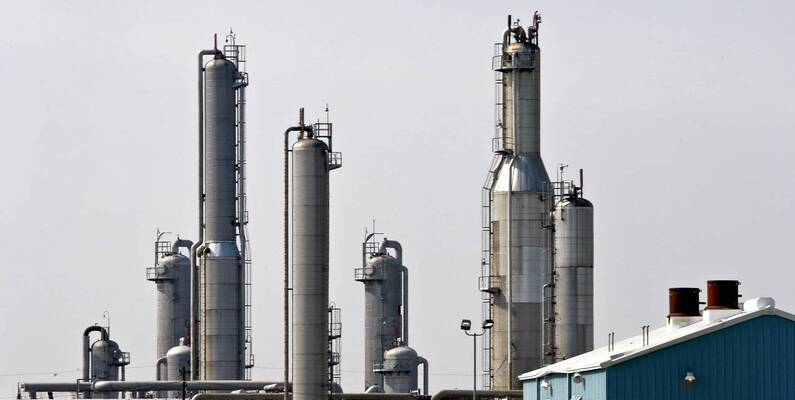

Natural gas is a fossil energy source that formed deep beneath the earth's surface. Natural gas contains many different compounds. The largest component of natural gas is methane, a compound with one carbon atom and four hydrogen atoms (CH4). Natural gas also contains smaller amounts of natural gas liquids (NGLs, which are also hydrocarbon gas liquids), and nonhydrocarbon gases, such as carbon dioxide and water vapor. We use natural gas as a fuel and to make materials and chemicals.

## The Henry Hub pipeline
The Henry Hub pipeline is the pricing point for natural gas futures on the New York Mercantile Exchange. The NYMEX contract for deliveries at Henry Hub began trading in 1990 and is deliverable 18 months in the future. The settlement prices at Henry Hub are used as benchmarks for the entire North American natural gas market and parts of the global liquid natural gas (LNG) market.

Henry Hub is an important market clearing pricing concept because it is based on the actual supply and demand of natural gas as a stand-alone commodity. Other natural gas markets like Europe have fragmented hub pricing points. This means natural gas prices are often indexed to crude oil, which can have very different supply and demand factors affecting its price. Attempts are being made to develop European hub pricing points in the Netherlands and the UK, but this has proved difficult so far due to competition from national hubs. Asian natural gas markets are even more fragmented and have no defined hub pricing point, although Singapore would like to serve this regional role. Consequently, all Asian natural gas prices are either indexed to crude oil or linked to Henry Hub.

## My approach
- First we extract tweets realated to the topic from twitter 
- Second we develop an RNN to get the value of the sentiment of a tweet
- Third we develop a model to use the sentiment extracted of the day and predict the Gas price value using it

In [8]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

## First Tweets extractor

In [18]:
def tweets_scraper(topic):
    # Creating list to append tweet data to
    attributes_container = []
    # Using TwitterSearchScraper to scrape data and append tweets to list
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(topic).get_items()):
        if i>150:
            break
        attributes_container.append([tweet.user.username, tweet.date, tweet.likeCount, tweet.sourceLabel, tweet.content])
    
    # Creating a dataframe to load the list
    tweets_df = pd.DataFrame(attributes_container, columns=["User", "Date Created", "Number of Likes", "Source of Tweet", "Tweet"])
    return tweets_df

In [20]:
today_tweets = tweets_scraper("Natural Gas")
today_tweets.shape

(151, 5)

In [22]:
today_tweets.head()

,User,Date Created,Number of Likes,Source of Tweet,Tweet
0,ngachoffat,2022-08-15 10:14:16+00:00,0,IFTTT,markets: Russia’s payment to Ukraine for natur...
1,peterg,2022-08-15 10:13:48+00:00,0,Twitter for iPhone,@charlesarthur @A_BoxOfRain So I understand ga...
2,jlgoncalez,2022-08-15 10:13:16+00:00,0,Twitter Web App,Senex supplies $1B boost to natural gas https:...
3,markets,2022-08-15 10:10:05+00:00,2,SocialFlow,Russia’s payment to Ukraine for natural gas tr...
4,JanLeschke,2022-08-15 10:09:20+00:00,0,Twitter Web App,@listentomesonny @orangesteel @EuromaidanPress...


## IMDB based classifier

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4UKFZX/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4UKFZX/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4UKFZX/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Word about the data
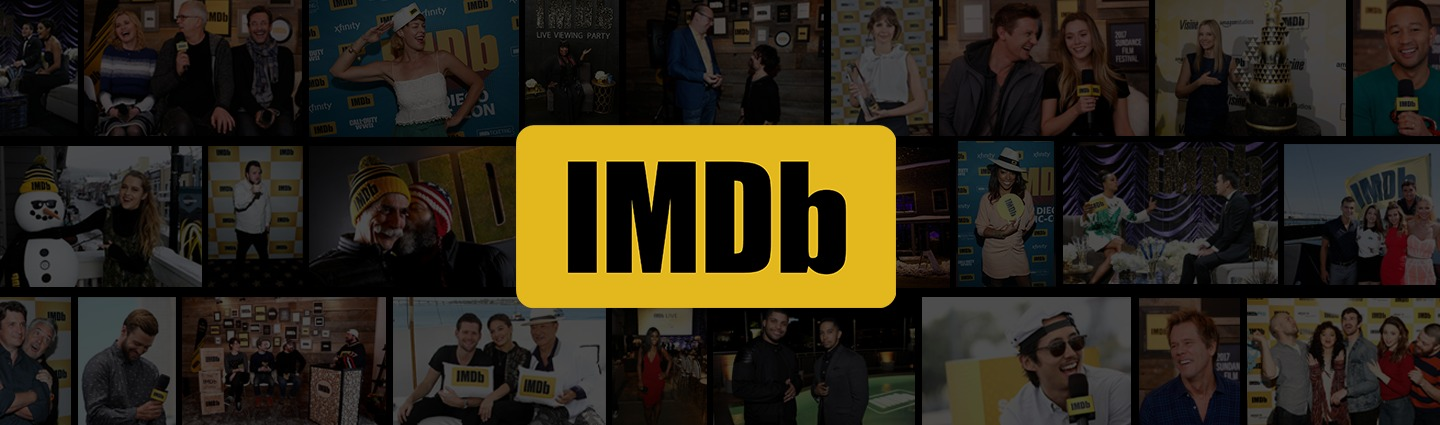

We will be using a dataset of 25,000 IMDB movie reviews, each of which has a sentiment label (positive/negative). Each review is preprocessed and encoded as a sequence of word indices (integers). For simplicity, words are indexed by overall frequency in the dataset, for instance the integer "3" encodes the 3rd most frequent word appearing in all reviews. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

In [72]:
train_data, test_data = imdb['train'], imdb['test']
train_sentenses = []
train_labels = []
test_sentenses = []
test_labels = []
for s,l in train_data:
    train_sentenses.append(str(s.numpy()))
    train_labels.append(l.numpy())
for s,l in test_data:
    test_sentenses.append(str(s.numpy()))
    test_labels.append(l.numpy())

In [112]:
train_sentenses[0]

'b"This was an absolutely terrible movie. Don\'t be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie\'s ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor\'s like Christopher Walken\'s good name. I could barely sit through it."'

In [108]:
train_labels[0]

0

In [73]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentenses)
word_index = tokenizer.word_index

train_seq = tokenizer.texts_to_sequences(train_sentenses)
pad_train = pad_sequences(train_seq, maxlen=280, truncating='post')

test_seq = tokenizer.texts_to_sequences(test_sentenses)
pad_test = pad_sequences(test_seq, maxlen=280, truncating='post')

In [75]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 64, input_length=280), 
    tf.keras.layers.Conv1D(64,10,activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [76]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 280, 64)           640000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 271, 64)           41024     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 271, 128)          66048     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [77]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [79]:
history = model.fit(pad_train, np.array(train_labels), epochs=5,
          validation_data=(pad_test, np.array(test_labels)), verbose=1)

Epoch 1/5
782/782 [==============================] - 253s 320ms/step - loss: 0.4769 - accuracy: 0.7726 - val_loss: 0.6030 - val_accuracy: 0.6085
Epoch 2/5
782/782 [==============================] - 247s 316ms/step - loss: 0.3240 - accuracy: 0.8692 - val_loss: 0.3751 - val_accuracy: 0.8330
Epoch 3/5
782/782 [==============================] - 247s 315ms/step - loss: 0.2654 - accuracy: 0.8953 - val_loss: 0.3402 - val_accuracy: 0.8434
Epoch 4/5
782/782 [==============================] - 247s 316ms/step - loss: 0.1813 - accuracy: 0.9333 - val_loss: 0.3863 - val_accuracy: 0.8588
Epoch 5/5
782/782 [==============================] - 247s 316ms/step - loss: 0.1113 - accuracy: 0.9624 - val_loss: 0.4559 - val_accuracy: 0.8507


In [80]:
model.save("tweet_classifier.h5")

In [81]:
# visualizing Embeddings
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)
reversed_word_index = dict([(v, k) for k, v in word_index.items()])

(10000, 64)


In [82]:
out_v = open('vecs.tsv', 'w', encoding='utf-8')
out_m = open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, 10000):
    word = reversed_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + '\n')
    out_v.write('/t'.join([str(x) for x in embeddings]) + '\n')
out_v.close()
out_m.close()

In [85]:
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

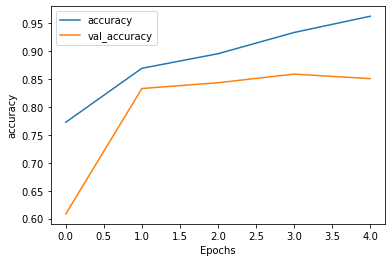

In [103]:
plot_graph(history, "accuracy")

In [128]:
def predict_tweet(review):
    rev_seq = tokenizer.texts_to_sequences(review)
    print(rev_seq)
    pad_rev = pad_sequences(rev_seq, maxlen=280, truncating='post')
    return np.interp(model.predict([[pad_rev]]), [0, 1], [-1, 1])

In [129]:
predict_tweet(["natural gas prices are expected to be reallylow due to war and this will be devastating for the economy"])

[[1265, 2567, 1, 25, 881, 6, 29, 1, 696, 6, 329, 3, 12, 81, 29, 6417, 16, 2, 8311]]


array([[-0.22639084]])

In [130]:
predict_tweet(["It's believed that oil prices will rise which is great for the economy "])

[[103, 2443, 13, 3288, 1, 81, 2229, 65, 7, 88, 16, 2, 8311]]


array([[0.9139874]])

## Time Series Model

In mathematics, a time series is a series of data points indexed (or listed or graphed) in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data.

## EDA for the main dataset

In [135]:
ts_df = pd.read_csv("dataset/data.csv")

In [136]:
ts_df.head()

,Unnamed: 0,Day,Price,Sentiment
0,0,20150105,3.22,-0.534077
1,1,20150106,2.98,-0.337025
2,2,20150107,3.08,-0.065357
3,3,20150108,2.92,-0.326590
4,4,20150109,2.96,-0.374404


In [139]:
ts_df.describe()

,Unnamed: 0,Day,Price,Sentiment
count,1874.000000,1.874000e+03,1874.000000,1874.000000
mean,936.500000,2.018235e+07,2.918623,-0.299520
std,541.121521,2.119460e+04,1.050903,0.192107
min,0.000000,2.015010e+07,0.000000,-0.819287
25%,468.250000,2.016103e+07,2.390000,-0.435230
50%,936.500000,2.018082e+07,2.790000,-0.313156
75%,1404.750000,2.020062e+07,3.070000,-0.158241
max,1873.000000,2.022050e+07,23.860000,0.693440


In [145]:
ts_df.isnull().sum()

Unnamed: 0    0
Day           0
Price         0
Sentiment     0
dtype: int64

In [147]:
import datetime
ts_df['Day'] = ts_df["Day"].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))

In [148]:
ts_df.head()

,Unnamed: 0,Day,Price,Sentiment
0,0,2015-01-05,3.22,-0.534077
1,1,2015-01-06,2.98,-0.337025
2,2,2015-01-07,3.08,-0.065357
3,3,2015-01-08,2.92,-0.326590
4,4,2015-01-09,2.96,-0.374404


## Data visualization and preprocessing

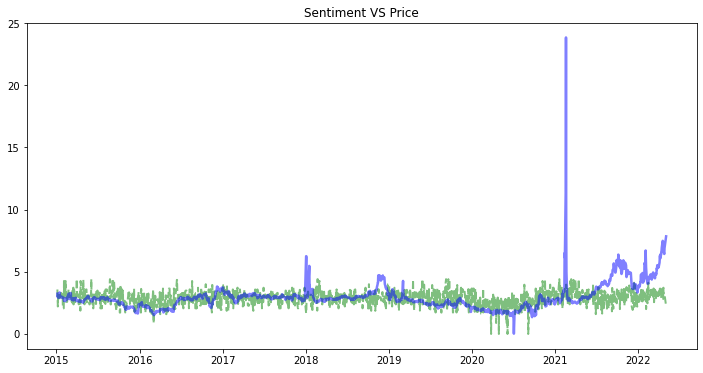

In [159]:
avg = sum(list(ts_df.Price))/len(list(ts_df.Price))
sen = list(ts_df.Sentiment)
day = ts_df.Day
price = list(ts_df.Price)
for i in range (len(sen)):
    sen[i] = -(sen[i]*avg)+2
plt.figure(figsize=(12, 6))
l1 = plt.plot(day, sen, lw = 2, color='green', alpha=0.5, linestyle='dashed')
l2 = plt.plot(day, price, lw = 2.5, color='blue', alpha=0.5)
plt.title('Sentiment VS Price')
plt.show()

In [213]:
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df)-window):
        res = []
        for j in range(0, window):
            res.append([ts_df.Price[i+j], ts_df.Sentiment[i+j]])
        res.append([0, ts_df.Sentiment[i+window]])
        xRes.append(res)
        yRes.append(ts_df.Price[i+window])
    tf.convert_to_tensor(xRes)
    return (tf.convert_to_tensor(xRes), tf.convert_to_tensor(yRes))

In [215]:
SPLIT = 0.85
xVal, yVal = singleStepSampler(ts_df, 20)
xTrain = xVal[:int(SPLIT*len(xVal))]
yTrain = yVal[:int(SPLIT*len(yVal))]
xTest = xVal[int(SPLIT*len(xVal)):]
yTest = yVal[int(SPLIT*len(yVal)):]
(xTrain.shape, xTest.shape)

(TensorShape([1575, 21, 2]), TensorShape([279, 21, 2]))

## Modeling

In [224]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, (3), input_shape=(21, 2)),
    tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding="valid"),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear")
])

In [225]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae'])

In [226]:
history = model.fit(xTrain, yTrain, epochs=50)

Epoch 1/50
50/50 [==============================] - 3s 31ms/step - loss: 0.3756 - mse: 0.6534 - mae: 0.3756
Epoch 2/50
50/50 [==============================] - 1s 29ms/step - loss: 0.2541 - mse: 0.4391 - mae: 0.2541
Epoch 3/50
50/50 [==============================] - 1s 29ms/step - loss: 0.2053 - mse: 0.3921 - mae: 0.2053
Epoch 4/50
50/50 [==============================] - 1s 29ms/step - loss: 0.1791 - mse: 0.3405 - mae: 0.1791
Epoch 5/50
50/50 [==============================] - 1s 29ms/step - loss: 0.1584 - mse: 0.3036 - mae: 0.1584
Epoch 6/50
50/50 [==============================] - 2s 30ms/step - loss: 0.1497 - mse: 0.2809 - mae: 0.1497
Epoch 7/50
50/50 [==============================] - 2s 31ms/step - loss: 0.1338 - mse: 0.2637 - mae: 0.1338
Epoch 8/50
50/50 [==============================] - 2s 30ms/step - loss: 0.1315 - mse: 0.2455 - mae: 0.1315
Epoch 9/50
50/50 [==============================] - 2s 30ms/step - loss: 0.1250 - mse: 0.2376 - mae: 0.1250
Epoch 10/50
50/50 [=========

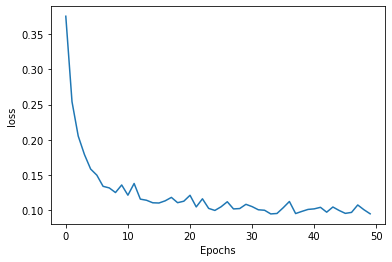

In [229]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [230]:
model.save("time series.h5")

In [232]:
model_values = []
for item in xTest:
    model_values.append(model.predict(np.array([item])))

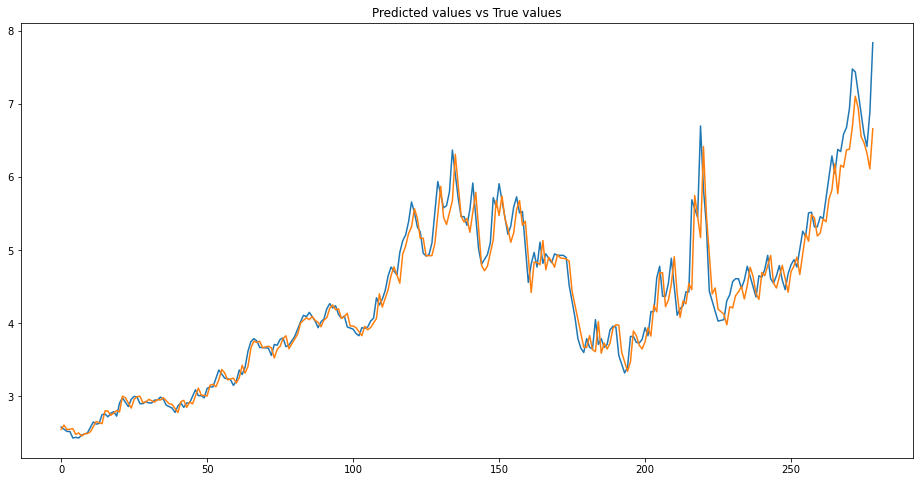

In [234]:
dafr = pd.DataFrame(data={'actual': yTest, 'Modelled': [item[0][0] for item in model_values]})
plt.figure(figsize=(16, 8))
plt.title("Predicted values vs True values")
plt.plot(dafr)
plt.show()

## Extracting Sentiment for new predictions

In [236]:
tweets = today_tweets.Tweet

In [237]:
tweets.head()

0    markets: Russia’s payment to Ukraine for natur...
1    @charlesarthur @A_BoxOfRain So I understand ga...
2    Senex supplies $1B boost to natural gas https:...
3    Russia’s payment to Ukraine for natural gas tr...
4    @listentomesonny @orangesteel @EuromaidanPress...
Name: Tweet, dtype: object

In [243]:
sen_model = tf.keras.models.load_model("tweet_classifier.h5")

In [245]:
def predict_tweet(review):
    rev_seq = tokenizer.texts_to_sequences(review)
    print(rev_seq)
    pad_rev = pad_sequences(rev_seq, maxlen=280, truncating='post')
    return np.interp(sen_model.predict([[pad_rev]]), [0, 1], [-1, 1])

In [247]:
predict_tweet([tweets.to_numpy()[0]])

[[1, 1, 1, 6, 1, 16, 1265, 2567, 1, 12, 3232, 48, 836, 145, 206, 719, 62, 104, 4, 1, 17, 4, 738, 3288, 1, 6875, 136, 1, 790, 1015, 1]]


array([[-0.99269938]])

In [248]:
def avg_sentiment(df):
    np = df.to_numpy()
    _sum = 0
    for i in np:
        _sum += predict_tweet([i])
    avg = _sum/len(np)
    return avg

In [249]:
avg_sentiment(tweets)

[[1, 1, 1, 6, 1, 16, 1265, 2567, 1, 12, 3232, 48, 836, 145, 206, 719, 62, 104, 4, 1, 17, 4, 738, 3288, 1, 6875, 136, 1, 790, 1015, 1]]
[[1, 4, 1, 37, 11, 397, 2567, 7, 1335, 5, 9097, 3, 452, 1589, 1, 37, 2315, 1, 99, 3173, 9097, 1, 46, 33, 564, 1, 241, 38, 4147, 1854, 3, 5319, 13, 1265, 2567, 1, 752, 262, 3694, 14, 2986, 32, 1767, 64, 1379, 97, 50, 1500]]
[[1, 9812, 1, 8961, 6, 1265, 2567, 1, 790, 1015, 1]]
[[1, 1, 6, 1, 16, 1265, 2567, 1, 12, 3232, 48, 836, 145, 206, 719, 62, 104, 4, 1, 17, 4, 738, 3288, 1, 6875, 136, 1, 790, 1015, 1]]
[[1, 1, 1, 1265, 2567, 38, 126, 7423, 1, 2299, 48, 6380, 1, 16, 1788, 2567, 17, 50, 3136, 16, 473, 2, 8514, 7057, 1, 9523, 529, 3, 135, 3136, 28, 78, 1, 1, 16, 112, 155, 95, 217, 323, 5, 2, 1788, 2567, 13, 14]]
[[1, 236, 1265, 2567, 84, 48, 78, 348, 16, 1, 16, 12, 1, 48, 78, 2871, 15, 74, 67, 2299, 15, 193, 1265, 2567, 1, 48, 80, 916, 1220, 3925, 2757, 100, 77, 94, 1, 38, 5433]]
[[262, 554, 8895, 2223, 5, 4909, 1, 13, 58, 527, 22, 350, 1265, 2567, 42, 4

[[9, 2, 691, 3232, 5, 7081, 1, 48, 1, 2, 4855, 5, 187, 236, 5, 94, 1, 1, 599, 7156, 1, 1, 5, 1265, 2567, 1, 4715, 4715, 3, 1, 1, 5, 2658, 3288, 1, 4715, 4715, 1, 1, 790, 1015, 1]]
[[656, 5, 1, 9, 2848, 2567, 1, 1, 9, 1, 15, 5, 6835, 1, 1729, 1, 2567, 1, 1, 790, 1015, 1]]
[[1, 582, 1, 2, 895, 91, 83, 23, 1, 2, 2367, 1854, 5, 1265, 2567, 206, 1, 1, 1, 1, 39, 1, 1, 37, 13, 311, 58, 3198, 716, 1, 1, 280, 3198, 1094, 306, 1, 790, 1015, 1]]
[[1, 1, 1743, 2567, 6380, 38, 5433, 1, 1, 48, 6538, 6, 2936, 26, 2289, 651, 17, 1, 9, 2761, 5, 1, 4817, 5, 1, 337, 53, 33, 1, 1, 1, 790, 1015, 1]]
[[1, 1265, 2567, 99, 342, 613, 181, 2, 1180, 5, 1, 38, 2, 1, 1612, 12, 7, 51, 75, 25, 407, 6, 2503, 2, 368, 5, 1, 1, 790, 1015, 1]]
[[1, 1, 1, 7, 13, 2, 179, 7, 736, 6, 2209, 1729, 470, 92, 159, 8161, 206, 2, 159, 978, 7, 9, 1, 1265, 2567, 3, 3528, 8549, 1, 9, 1, 3, 81, 7716, 4, 1224, 2913, 6979, 46, 87, 10, 7, 24, 1, 1654, 1993, 1729, 5655, 1, 1, 790, 1015, 1]]
[[3285, 1, 1, 39, 3288, 8549, 3, 1265, 2567, 2919

[[1265, 2567, 1, 9, 2375, 2241, 15, 4, 902, 1511, 1, 57, 2, 1, 6984, 3, 1, 2567, 1, 13, 71, 2480, 78, 1, 1, 2375, 1, 790, 1015, 1]]
[[1, 1, 9, 191, 9, 2, 1, 689, 8311, 2721, 48, 421, 35, 681, 4387, 9, 2, 5466, 3691, 2, 4755, 1854, 5, 1788, 1265, 2567, 6, 2, 1259, 48, 2202, 4, 1054, 3447, 51, 81, 2721, 1220, 1022, 1, 5260, 414, 19, 83, 24, 4287, 98]]
[[1, 1, 1830, 667, 45, 1302, 1, 7576, 1, 5, 1, 8549, 1, 1520, 5, 94, 3288, 892, 5, 94, 1265, 2567, 1, 5, 94, 1, 1, 9659, 5, 94, 1299, 1, 5433, 150, 7576, 32, 219, 1713, 480, 1, 292, 5, 1, 1339, 1265, 4774, 599, 1729, 1, 1, 1]]
[[1, 1, 1, 236, 10, 14, 4, 2137, 6, 1, 1265, 2567, 1, 13, 1502, 2467, 163, 6, 83, 17, 1, 1, 678, 1, 7, 3923, 33, 1, 665, 46, 1, 262, 1, 25, 1, 1, 2, 1848, 1, 6, 192, 5155, 126, 1, 5981, 1]]
[[1, 1395, 675, 1180, 5, 1, 1, 15, 4, 1, 2567, 65, 1, 2, 2567, 38, 15, 554, 1, 15, 2, 4096, 1265, 2567, 1, 577, 29, 1, 3, 128, 24, 6977, 1444, 1, 9, 191, 1, 7, 1, 348, 9, 975, 1, 6, 276, 46, 975, 1, 790, 1015, 1]]
[[1, 1265, 2567, 

array([[-0.495814]])

## Now we can use the new sentiment value of this day and use it to extend the data frame of to be used for further training and prefictions